<a href="https://colab.research.google.com/github/abhilash-git/learning/blob/main/amortization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime,date,timedelta
import calendar
def getMonthwithIndex(index=0,date_in=datetime.now(),backward=False):
    days_in_month=0
    date_in = date_in.replace(day=1)
    for i in range(index):
      days_in_month = calendar.monthrange(date_in.year, date_in.month)[1]
      if backward:
        date_in=date_in - timedelta(days=days_in_month)
      else:
        date_in = date_in + timedelta(days=days_in_month)
    return date_in
    

In [2]:
!pip install numpy-financial
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.float_format', lambda x: '%.5f' % x)

class Loan:
  def __init__(self, principle_amount, interest_in_year, period_in_years,starting_date=datetime.now()):
    self.starting_date = starting_date
    self.principle_amount = principle_amount
    self.interest_in_year = interest_in_year
    self.period_in_years = period_in_years
    self.column_names = ["MONTH", "STARTING_AMOUNT", "EMI_AMOUNT", "INTEREST_PAID", "PRINCIPLE_PAID", "LEFTOVER_PRINCIPLE"]
    self.df = pd.DataFrame(columns = self.column_names)
    self.orginal_df = pd.DataFrame(columns = self.column_names)
    self.emi_amount = npf.pmt((interest_in_year/100)/12, period_in_years*12, -principle_amount,0)
    self.Principle_paid=0
    self.Interest_paid=0
    self.advancePayments=[]

  def getPrincipleAmount(self):
      return self.principle_amount

  def setPrincipleAmount(self,amt):
    self.principle_amount = amt;

  def getDataFrame(self):
    return self.df

  def populateDateFrame(self):
    temp_emi = self.emi_amount
    period_in_months = int(round(self.period_in_years*12))
    print("called {}".format(period_in_months))
    for i in range(0,period_in_months):
      temp_list_one_row=[]
      # print(i)
      if self.getPrincipleAmount() < 1:
        print("Break")
        break;
      temp_list_one_row.append(getMonthwithIndex(i+1,self.starting_date).date())
      temp_list_one_row.append(self.getPrincipleAmount())
      self.Interest_paid=(self.getPrincipleAmount()*(self.interest_in_year/100)/12)
      if self.getPrincipleAmount() < self.emi_amount:
        print("EMI changed P={} I={}".format(self.getPrincipleAmount() , self.Interest_paid))
        self.emi_amount=self.getPrincipleAmount() + self.Interest_paid
      temp_list_one_row.append(self.emi_amount)
      temp_list_one_row.append(self.Interest_paid)
      self.Principle_paid = self.emi_amount - self.Interest_paid
      temp_list_one_row.append(self.Principle_paid)
      temp_list_one_row.append(self.getPrincipleAmount() - self.Principle_paid)
      self.setPrincipleAmount(self.getPrincipleAmount() - self.Principle_paid)

      # print(temp_list_one_row)
      self.df = self.df.append(pd.Series(temp_list_one_row, index=self.column_names), ignore_index=True)

    self.emi_amount = temp_emi 
    if self.orginal_df.empty:
      self.orginal_df = self.df.copy(deep=True)



  def adjustWithAdvancePayment(self, payment_date, paid_amount):
    temp_list1=[]
    self.period_in_years = round((self.df[self.df.MONTH > payment_date.date()].shape[0] -1 )/12, 5)
    print("Printing year {}".format(self.period_in_years))
    self.setPrincipleAmount(self.df[self.df.MONTH==payment_date.date()].LEFTOVER_PRINCIPLE.item())
    self.df.drop(self.df[self.df.MONTH> payment_date.date()].index, inplace=True)
    self.starting_date=getMonthwithIndex(1, payment_date)
    temp_list1.append(self.starting_date.date())
    temp_list1.append(self.getPrincipleAmount())
    temp_list1.append(self.emi_amount)
    self.Interest_paid=(self.getPrincipleAmount()*(self.interest_in_year/100)/12)
    temp_list1.append(self.Interest_paid)
    advance_paid = paid_amount - self.Interest_paid;
    self.advancePayments.append(advance_paid);
    print("Printing advance_paid {}".format(advance_paid))
    self.Principle_paid = (self.emi_amount - self.Interest_paid) + advance_paid;
    temp_list1.append(self.Principle_paid)
    temp_list1.append(self.getPrincipleAmount() - self.Principle_paid)
    self.setPrincipleAmount(self.getPrincipleAmount() - self.Principle_paid)
    # print(temp_list1)
    self.df = self.df.append(pd.Series(temp_list1, index=self.column_names), ignore_index=True)
    self.populateDateFrame()


  def getTrend(self,deviation=False):
    if not self.df.empty and not self.orginal_df.empty and deviation:
      deviation=True;
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].plot(self.df.MONTH,self.df.STARTING_AMOUNT,color="blue")
    axes[1].plot(self.df.MONTH,self.df.PRINCIPLE_PAID,color="red")
    if deviation:
      axes[0].plot(self.orginal_df.MONTH,self.orginal_df.STARTING_AMOUNT,color="green")
      axes[1].plot(self.orginal_df.MONTH,self.orginal_df.PRINCIPLE_PAID,color="green")

    fig.tight_layout()

    plt.show()
    if deviation:
      print("You would have paid {} and with advance payment you paid {} ".format(self.orginal_df.EMI_AMOUNT.sum() , self.df.EMI_AMOUNT.sum()))
      print("Your saving is {} out of which advance principle paid is {}".format(self.orginal_df.EMI_AMOUNT.sum() - self.df.EMI_AMOUNT.sum(), 
                                                                       sum(self.advancePayments)))
      print("You saved {} in interest".format(self.orginal_df.EMI_AMOUNT.sum() - self.df.EMI_AMOUNT.sum() - sum(self.advancePayments)))



In [3]:
print("provide the date of Disbursement")
# year = int(input('Enter a year :'))
year=2020
# month = int(input('Enter a month :'))
month=5
# day = int(input('Enter a day :'))
day=5
date1 = datetime(year, month, day, 00, 00, 00, 00)
# print(date1)

provide the date of Disbursement


In [4]:
print("Provide details of Loan")
# amount = int(input('Enter principle amount :'))
amount=10000000
# rate = float(input('Enter the rate of interest accepted :'))
rate=12
# duration = int(input('Enter the duration in years :'))
duration=30

Provide details of Loan


In [5]:

obj1=Loan(amount,rate,duration,date1)


In [6]:
obj1.populateDateFrame()

called 360
EMI changed P=101842.83137877221 I=1018.428313787722


In [7]:
obj1.getDataFrame()

,MONTH,STARTING_AMOUNT,EMI_AMOUNT,INTEREST_PAID,PRINCIPLE_PAID,LEFTOVER_PRINCIPLE
0,2020-06-01,10000000,102861.25969,100000.00000,2861.25969,9997138.74031
1,2020-07-01,9997138.74031,102861.25969,99971.38740,2889.87229,9994248.86802
2,2020-08-01,9994248.86802,102861.25969,99942.48868,2918.77101,9991330.09701
3,2020-09-01,9991330.09701,102861.25969,99913.30097,2947.95872,9988382.13828
4,2020-10-01,9988382.13828,102861.25969,99883.82138,2977.43831,9985404.69997
...,...,...,...,...,...,...
355,2050-01-01,499230.05111,102861.25969,4992.30051,97868.95918,401361.09193
356,2050-02-01,401361.09193,102861.25969,4013.61092,98847.64877,302513.44315
357,2050-03-01,302513.44315,102861.25969,3025.13443,99836.12526,202677.31789
358,2050-04-01,202677.31789,102861.25969,2026.77318,100834.48651,101842.83138


In [8]:
obj1.adjustWithAdvancePayment(payment_date=datetime(2049, 1, 1, 00, 00, 00, 00),paid_amount=400000)

Printing year 1.25
Printing advance_paid 384861.009630582
called 15
EMI changed P=74104.0646621317 I=741.040646621317
Break


In [9]:
obj1.adjustWithAdvancePayment(payment_date=datetime(2049, 4, 1, 00, 00, 00, 00),paid_amount=400000)

Printing year 0.66667
Printing advance_paid 391445.0492725838
called 8
EMI changed P=69267.41580268908 I=692.6741580268908
Break


In [10]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
obj1.getDataFrame()

,MONTH,STARTING_AMOUNT,EMI_AMOUNT,INTEREST_PAID,PRINCIPLE_PAID,LEFTOVER_PRINCIPLE
0,2020-06-01,10000000,102861.25969,100000.00000,2861.25969,9997138.74031
1,2020-07-01,9997138.74031,102861.25969,99971.38740,2889.87229,9994248.86802
2,2020-08-01,9994248.86802,102861.25969,99942.48868,2918.77101,9991330.09701
3,2020-09-01,9991330.09701,102861.25969,99913.30097,2947.95872,9988382.13828
4,2020-10-01,9988382.13828,102861.25969,99883.82138,2977.43831,9985404.69997
5,2020-11-01,9985404.69997,102861.25969,99854.04700,3007.21269,9982397.48728
6,2020-12-01,9982397.48728,102861.25969,99823.97487,3037.28482,9979360.20246
7,2021-01-01,9979360.20246,102861.25969,99793.60202,3067.65767,9976292.54479
8,2021-02-01,9976292.54479,102861.25969,99762.92545,3098.33424,9973194.21055
9,2021-03-01,9973194.21055,102861.25969,99731.94211,3129.31759,9970064.89296


In [11]:
# a.getDataFrame()[a.getDataFrame()[MONTH==datetime(2049, 1, 1, 00, 00, 00, 00).date()]]
obj1.getDataFrame()[obj1.getDataFrame().MONTH> datetime(2021, 12, 1, 00, 00, 00, 00).date()]

,MONTH,STARTING_AMOUNT,EMI_AMOUNT,INTEREST_PAID,PRINCIPLE_PAID,LEFTOVER_PRINCIPLE
19,2022-01-01,9940454.62484,102861.25969,99404.54625,3456.71344,9936997.91140
20,2022-02-01,9936997.91140,102861.25969,99369.97911,3491.28058,9933506.63082
21,2022-03-01,9933506.63082,102861.25969,99335.06631,3526.19338,9929980.43744
22,2022-04-01,9929980.43744,102861.25969,99299.80437,3561.45532,9926418.98212
23,2022-05-01,9926418.98212,102861.25969,99264.18982,3597.06987,9922821.91225
24,2022-06-01,9922821.91225,102861.25969,99228.21912,3633.04057,9919188.87168
25,2022-07-01,9919188.87168,102861.25969,99191.88872,3669.37098,9915519.50070
26,2022-08-01,9915519.50070,102861.25969,99155.19501,3706.06469,9911813.43602
27,2022-09-01,9911813.43602,102861.25969,99118.13436,3743.12533,9908070.31068
28,2022-10-01,9908070.31068,102861.25969,99080.70311,3780.55659,9904289.75410


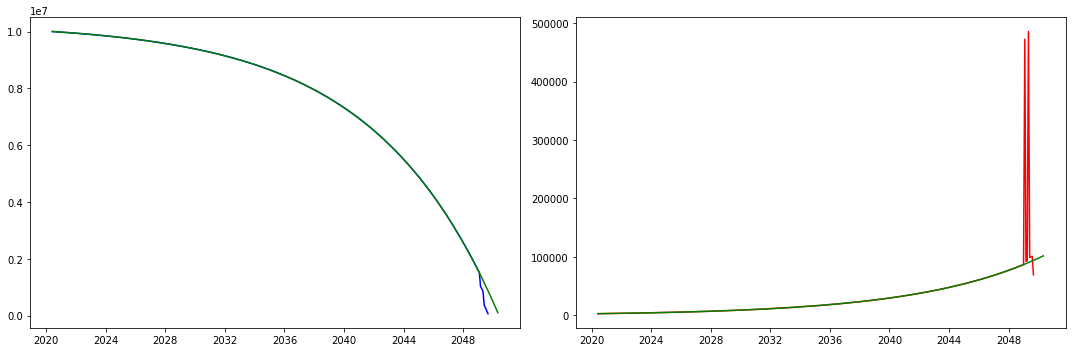

You would have paid 37030053.48931816 and with advance payment you paid 36174262.24204592 
Your saving is 855791.2472722456 out of which advance principle paid is 776306.0589031659
You saved 79485.18836907973 in interest


In [12]:
obj1.getTrend(deviation=True)